# Stanford dogs: breed classifier

## 1. Import libraries and define data folders

In [1]:
# files loading
import os

from random import shuffle
import numpy as np
!pip install tqdm
from tqdm import tqdm # progress bar

In [2]:
# image pretreatment
import matplotlib.pyplot as plt

import cv2
import numpy as np

from PIL import Image

In [3]:
#horizontal flip image augmentation libraries

import keras
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.vis_utils import plot_model

In [4]:
import imageio
import imgaug as ia
from imgaug import augmenters as iaa
# 

In [5]:
from sklearn.model_selection import train_test_split


In [6]:
# libraries for a CNN
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout
from keras.layers.normalization import BatchNormalization
from keras.layers import GlobalAveragePooling2D
from keras.layers import Dropout, Activation

from tensorflow.python.client import device_lib


In [7]:
#gpus = tf.config.experimental.list_physical_devices('GPU')
#for gpu in gpus:
#    tf.config.experimental.set_memory_growth(gpu, True)


In [8]:
#print(device_lib.list_local_devices())
#print(tf.config.list_physical_devices('GPU'))
#print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
# confirm TensorFlow sees the GPU
#from tensorflow.python.client import device_lib
#assert 'GPU' in str(device_lib.list_local_devices())

In [9]:
tf.__version__

'2.2.0'

In [10]:
#tf.test.is_built_with_cuda()

In [11]:
#tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None)

In [12]:
ANNOTATION_DIR = '/media/marco/DATA/OC_Machine_learning/section_6/DATA/Annotation/' 
IMAGES_DIR = '/media/marco/DATA/OC_Machine_learning/section_6/DATA/Images/'

### 1.1 Visualize list of breeds (classes) and a sample data (image)

In [13]:
breed_list = os.listdir(IMAGES_DIR)
print("num. breeds total:", len(breed_list))

num. breeds total: 120


In [14]:
filtered_breeds = [breed.split('-',1)[1] for breed in breed_list] #visualize breeds
filtered_breeds[:10]

['Chihuahua',
 'Japanese_spaniel',
 'Maltese_dog',
 'Pekinese',
 'Shih-Tzu',
 'Blenheim_spaniel',
 'papillon',
 'toy_terrier',
 'Rhodesian_ridgeback',
 'Afghan_hound']

## 1.2 Example equalization 

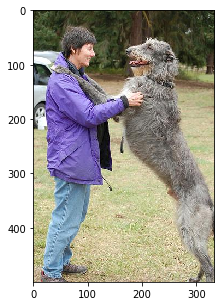

In [15]:
## set the seed for the np.random module, so we always get the same image when run this code cell
np.random.seed(11)

# since we just want one image, I'll ramdomly choose a breed and a dog from that breed
breed = np.random.choice(breed_list)
dog = np.random.choice(os.listdir(ANNOTATION_DIR + breed))

# opening one image
img = cv2.imread(IMAGES_DIR + breed + '/' + dog + '.jpg') 
# this line is necessary because cv2 reads an image in BGR format (Blue, Green, Red) by default. 
# So we will convert it to RGB
img_RGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
img_grayscale = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
img_to_yuv = cv2.cvtColor(img,cv2.COLOR_BGR2YUV)
plt.figure(figsize = (5,5))
plt.imshow(img_RGB)

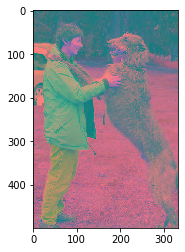

In [16]:
plt.imshow(img_to_yuv)

image above shows that we have humans together with dogs

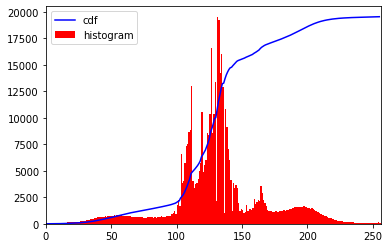

In [17]:
hist,bins = np.histogram(img_to_yuv.flatten(),256,[0,256])
cdf = hist.cumsum()
cdf_normalized = cdf * float(hist.max()) / cdf.max()
plt.plot(cdf_normalized, color = 'b')
plt.hist(img_to_yuv.flatten(),256,[0,256], color = 'r')
plt.xlim([0,256])
plt.legend(('cdf','histogram'), loc = 'upper left')
plt.show()

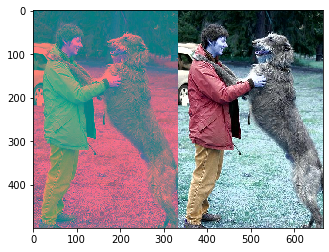

In [18]:
img_to_yuv[:,:,0] = cv2.equalizeHist(img_to_yuv[:,:,0])
equ = cv2.cvtColor(img_to_yuv, cv2.COLOR_YUV2BGR)
res = np.hstack((img_to_yuv,equ)) #stacking images side-by-side
cv2.imwrite('res.png',res)
plt.imshow(res)

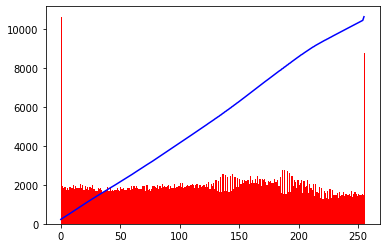

In [19]:
hist,bins = np.histogram(equ.flatten(),256,[0,256])
cdf = hist.cumsum()
cdf_normalized = cdf * float(hist.max()) / cdf.max()
plt.plot(cdf_normalized, color = 'b')
plt.hist(equ.flatten(),256,[0,256], color = 'r')
plt.show()

## 1.3 Example augmentations: mirroring and rotation

Augmented by mirroring:


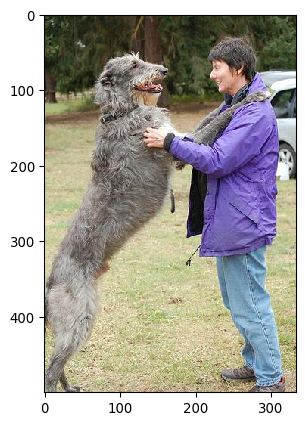

In [20]:
ia.seed(4)

rotate = iaa.Affine(rotate=(-60, 60))
image_aug_1 = rotate(image=img_RGB)
mirror = iaa.Fliplr(0.5)
image_aug_2 = mirror(image=img_RGB)
print("Augmented by mirroring:")
ia.imshow(image_aug_2)

Augmented by rotation:


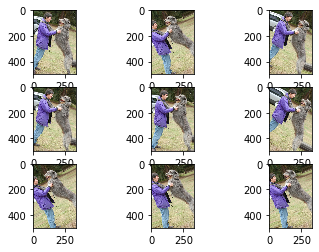

<Figure size 720x720 with 0 Axes>

In [21]:
print("Augmented by rotation:")
#ia.imshow(image_aug_2)
# convert to numpy array
data = img_to_array(img_RGB)

# expand dimension to one sample
samples = expand_dims(data, 0)
# create image data augmentation generator
datagen = ImageDataGenerator(rotation_range=30)
# prepare iterator
it = datagen.flow(samples, batch_size=1)
# generate samples and plot
for i in range(9):
    # define subplot
    plt.subplot(330 + 1 + i)
    # generate batch of images
    batch = it.next()
    # convert to unsigned integers for viewing
    image = batch[0].astype('uint8')
    # plot raw pixel data
    plt.imshow(image)
# show the figure
plt.figure(figsize = (10,10))
plt.show()

## 1.4 Batch processing - equalization and augmentation

In [22]:
num_breeds = 10 # integer between 2 and 120
breeds = breed_list[:num_breeds]

def load_images_and_labels(breeds):
    img_lst=[]
    labels=[]
    for index, breed in enumerate(breeds):
        for image_name in os.listdir(IMAGES_DIR+"/"+breed):
            img = cv2.imread(IMAGES_DIR+"/"+breed+"/"+image_name)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            img_to_yuv[:,:,0] = cv2.equalizeHist(img_to_yuv[:,:,0]) # convert to yuv color space for equalization
            equ = cv2.cvtColor(img_to_yuv, cv2.COLOR_YUV2RGB) # equalize
            
            img_array = Image.fromarray(img, 'RGB')
            
            #resize image to 227 x 227 because the input image resolution for AlexNet is 227 x 227
            resized_img = img_array.resize((227, 227))
            
            img_lst.append(np.array(resized_img))
            
            labels.append(index)
    return img_lst, labels

images, labels = load_images_and_labels(breeds)
print("No. of images loaded = ",len(images),"\nNo. of labels loaded = ",len(labels))
print(type(images),type(labels))

No. of images loaded =  1919 
No. of labels loaded =  1919
<class 'list'> <class 'list'>


In [23]:
images = np.array(images)
labels = np.array(labels)

print("Images shape = ",images.shape,"\nLabels shape = ",labels.shape)
print(type(images),type(labels))

Images shape =  (1919, 227, 227, 3) 
Labels shape =  (1919,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


## 2. Prepare data for training the CNN model

- For training the CNN model we have to shuffle all the data that is loaded in images, labels list.

### 2.1 data shuffling

In [24]:
#step 1 - get equally spaced numbers in a given range
n = np.arange(images.shape[0])
print("10 'n' values before shuffling = ",n[:10])

#shuffle all the equally spaced values in list 'n'
np.random.seed(42)
np.random.shuffle(n)
print("10 'n' values after shuffling = ",n[:10])

10 'n' values before shuffling =  [0 1 2 3 4 5 6 7 8 9]
10 'n' values after shuffling =  [1536 1370  610 1356  413 1073 1480  482  398 1723]


In [25]:
#step 2 - shuffle images and corresponding labels data in both the lists
images = images[n]
labels = labels[n]

print("Images shape after shuffling = ",images.shape,"\nLabels shape after shuffling = ",labels.shape)
print('same shapes before and after shuffling')

Images shape after shuffling =  (1919, 227, 227, 3) 
Labels shape after shuffling =  (1919,)
same shapes before and after shuffling


### 2.2 data normalization

In [26]:
images = images.astype(np.float32)
labels = labels.astype(np.int32)
images = images/255


### 2.3 test and train sets 

In [27]:
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size = 0.2, random_state = 42)

print("x_train shape = ",x_train.shape)
print("y_train shape = ",y_train.shape)
print("\nx_test shape = ",x_test.shape)
print("y_test shape = ",y_test.shape)

x_train shape =  (1535, 227, 227, 3)
y_train shape =  (1535,)

x_test shape =  (384, 227, 227, 3)
y_test shape =  (384,)


### 2.4 augment the training data.

In [28]:

aug = ImageDataGenerator(
        rotation_range=30,
        horizontal_flip=True,
        fill_mode='nearest')

# fit parameters from data
aug.fit(x_train, augment=True)

print("x_train shape = ",x_train.shape)
print("y_train shape = ",y_train.shape)
print("\nx_test shape = ",x_test.shape)
print("y_test shape = ",y_test.shape)

x_train shape =  (1535, 227, 227, 3)
y_train shape =  (1535,)

x_test shape =  (384, 227, 227, 3)
y_test shape =  (384,)


## 3. First CNN model

### 3.1 define layers

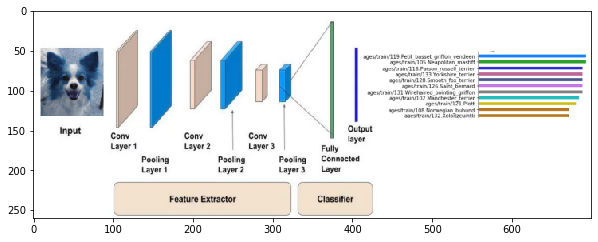

In [29]:
scheme = cv2.imread('first_model.png')
plt.figure(figsize = (10,5))
plt.imshow(scheme)

In [30]:
## inspired from http://machinememos.com/python/keras/artificial%20intelligence/machine%20learning/transfer%20learning/dog%20breed/neural%20networks/convolutional%20neural%20network/tensorflow/image%20classification/imagenet/2017/07/11/dog-breed-image-classification.html


model = Sequential()
# layer 1
model.add(Conv2D(16, (3, 3), padding='same', use_bias=False, input_shape=(227, 227, 3)))
model.add(BatchNormalization(axis=3, scale=False))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'))
model.add(Dropout(0.2))
# layer 2
model.add(Conv2D(32, (3, 3), padding='same', use_bias=False))
model.add(BatchNormalization(axis=3, scale=False))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'))
model.add(Dropout(0.2))
# layer 3
model.add(Conv2D(64, (3, 3), padding='same', use_bias=False))
model.add(BatchNormalization(axis=3, scale=False))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'))
model.add(Dropout(0.2))
# layer 4
model.add(Conv2D(128, (3, 3), padding='same', use_bias=False))
model.add(BatchNormalization(axis=3, scale=False))
model.add(Activation("relu"))
model.add(Flatten())
model.add(Dropout(0.2))
# fully connected layers
model.add(Dense(512, activation='relu'))
model.add(Dense(133, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 227, 227, 16)      432       
_________________________________________________________________
batch_normalization (BatchNo (None, 227, 227, 16)      48        
_________________________________________________________________
activation (Activation)      (None, 227, 227, 16)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 57, 57, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 57, 57, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 57, 57, 32)        4608      
_________________________________________________________________
batch_normalization_1 (Batch (None, 57, 57, 32)        9

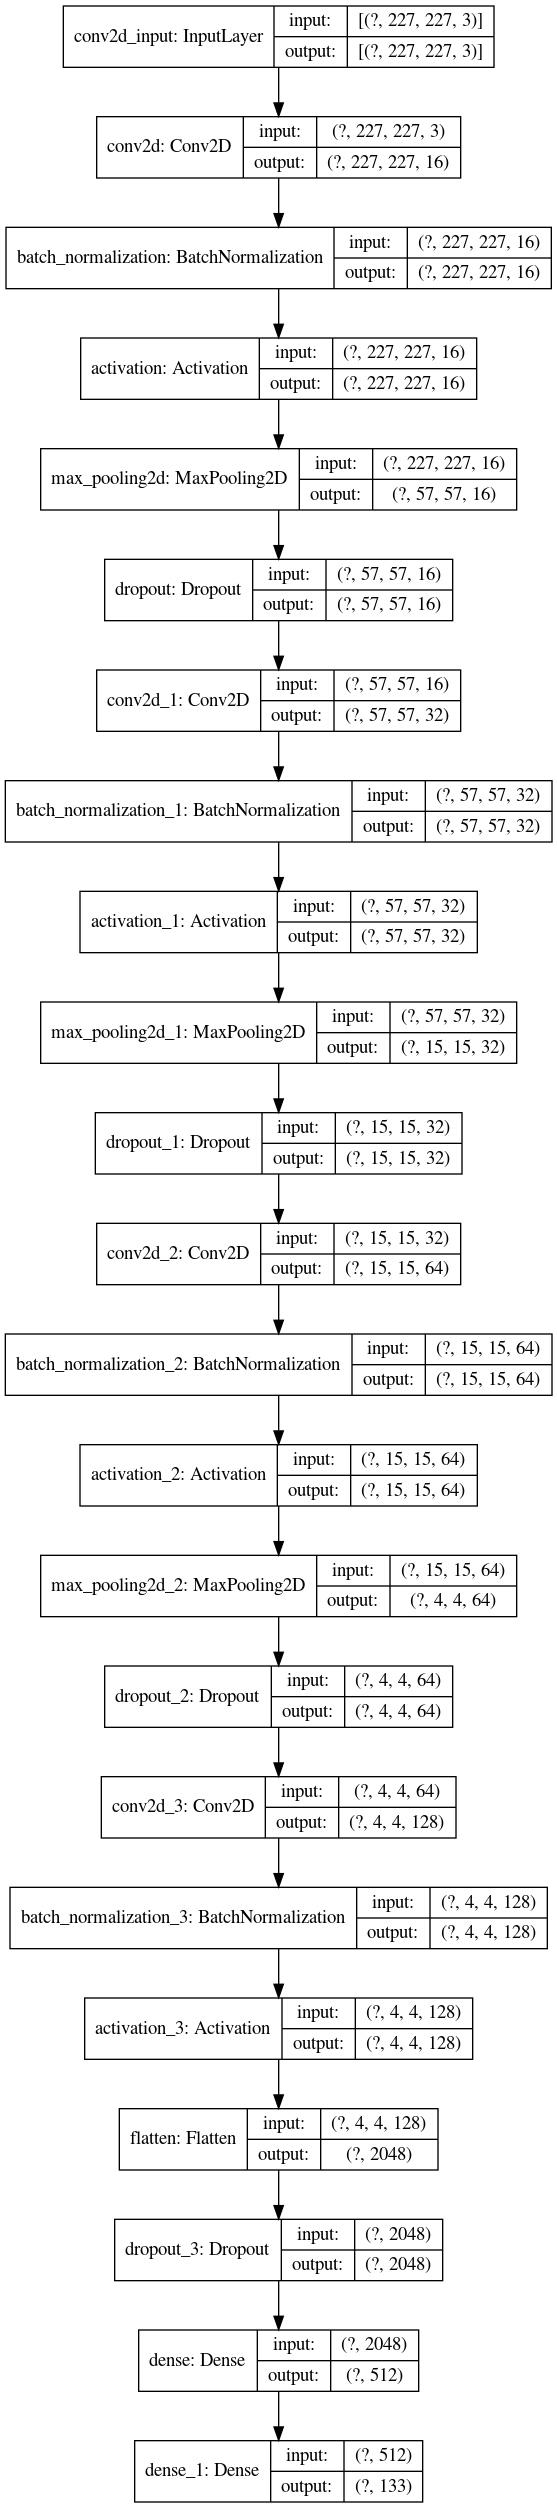

In [31]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

### 3.2 Compile the CNN model

In [32]:

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

### 3.3 Fit the model using training data

In [33]:
%%time
model.fit(aug.flow(x_train, y_train), epochs=25)


Epoch 1/25
48/48 [==============================] - 21s 434ms/step - loss: 2.5088 - accuracy: 0.1713
Epoch 2/25
48/48 [==============================] - 21s 435ms/step - loss: 2.1845 - accuracy: 0.2371
Epoch 3/25
48/48 [==============================] - 21s 436ms/step - loss: 2.0821 - accuracy: 0.2710
Epoch 4/25
48/48 [==============================] - 21s 433ms/step - loss: 1.9608 - accuracy: 0.3114
Epoch 5/25
48/48 [==============================] - 21s 434ms/step - loss: 1.8700 - accuracy: 0.3479
Epoch 6/25
48/48 [==============================] - 21s 433ms/step - loss: 1.8127 - accuracy: 0.3577
Epoch 7/25
48/48 [==============================] - 21s 437ms/step - loss: 1.7657 - accuracy: 0.4033
Epoch 8/25
48/48 [==============================] - 21s 435ms/step - loss: 1.6792 - accuracy: 0.4182
Epoch 9/25
48/48 [==============================] - 21s 436ms/step - loss: 1.6586 - accuracy: 0.4235
Epoch 10/25
48/48 [==============================] - 21s 432ms/step - loss: 1.6131 - accura

In [34]:
model.evaluate(x_test, y_test)

12/12 [==============================] - 1s 70ms/step - loss: 1.9397 - accuracy: 0.4245


[1.9397388696670532, 0.4244791567325592]

## 4. AlexNet

### 4.1 define layers

In [35]:
model=Sequential()

#1 conv layer
model.add(Conv2D(filters=96,kernel_size=(11,11),strides=(4,4),padding="valid",activation="relu",input_shape=(227,227,3)))

#1 max pool layer
model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))

model.add(BatchNormalization())

#2 conv layer
model.add(Conv2D(filters=256,kernel_size=(5,5),strides=(1,1),padding="valid",activation="relu"))

#2 max pool layer
model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))

model.add(BatchNormalization())

#3 conv layer
model.add(Conv2D(filters=384,kernel_size=(3,3),strides=(1,1),padding="valid",activation="relu"))

#4 conv layer
model.add(Conv2D(filters=384,kernel_size=(3,3),strides=(1,1),padding="valid",activation="relu"))

#5 conv layer
model.add(Conv2D(filters=256,kernel_size=(3,3),strides=(1,1),padding="valid",activation="relu"))

#3 max pool layer
model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))

model.add(BatchNormalization())


model.add(Flatten())

#1 dense layer
model.add(Dense(4096,input_shape=(227,227,3),activation="relu"))

model.add(Dropout(0.2))

model.add(BatchNormalization())

#2 dense layer
model.add(Dense(4096,activation="relu"))

model.add(Dropout(0.2))

model.add(BatchNormalization())

#3 dense layer
model.add(Dense(1000,activation="relu"))

model.add(Dropout(0.2))

model.add(BatchNormalization())

#output layer
model.add(Dense(20,activation="softmax"))


### 4.2 compile and run

In [36]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

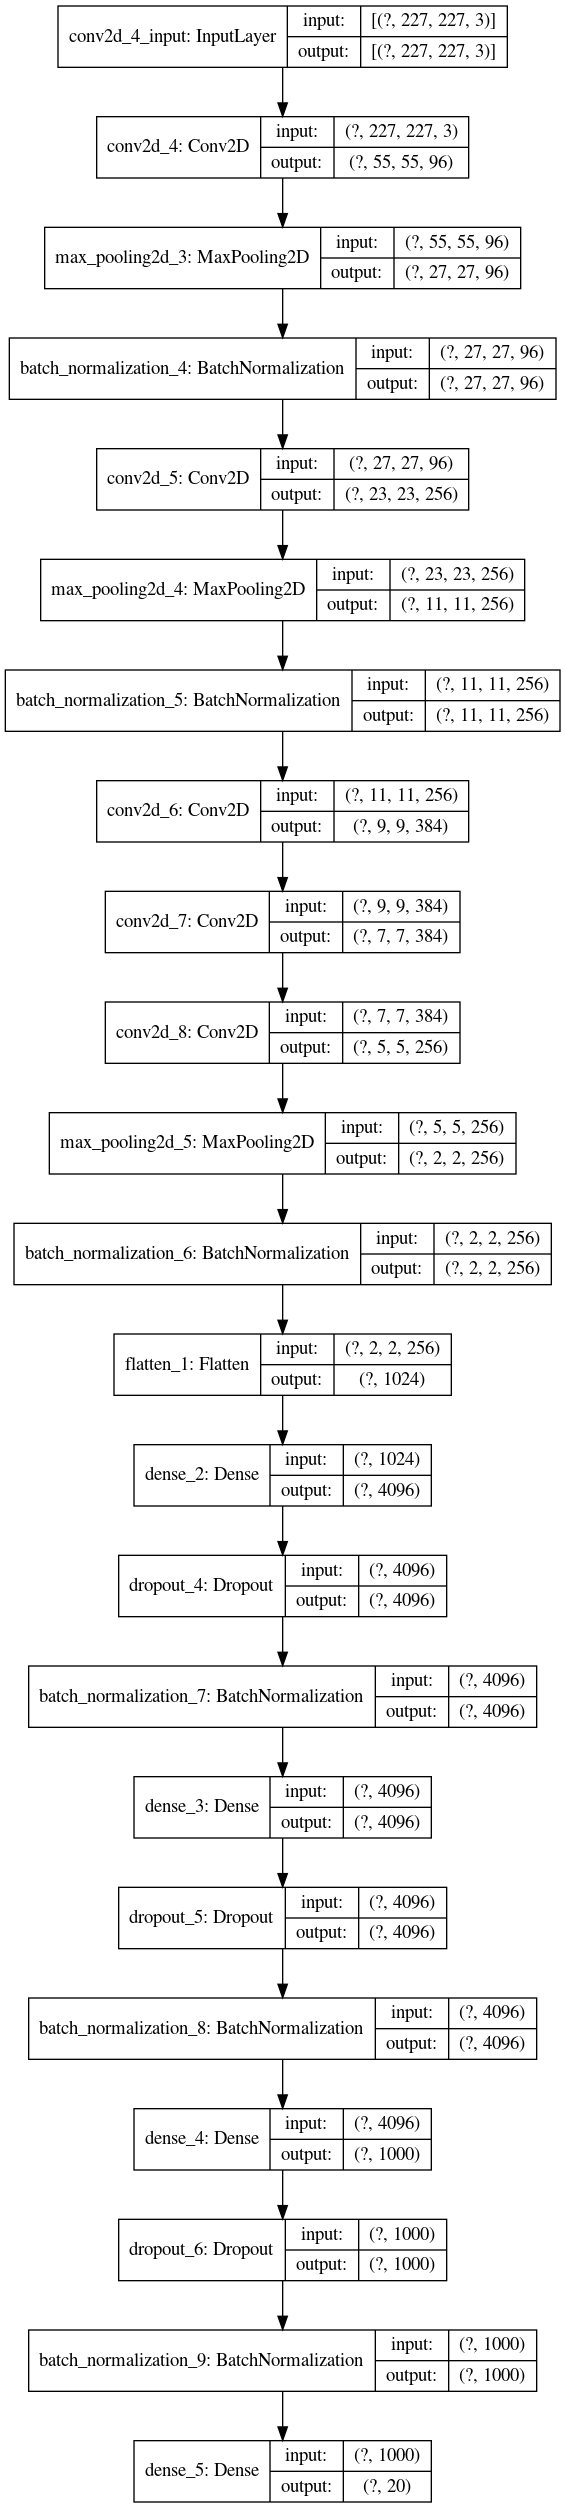

In [37]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [38]:
%%time
history = model.fit(aug.flow(x_train, y_train), 
          validation_data=(x_test, y_test),
          epochs=25)
#hist = model.fit(datagen.flow(x_train, y_train), epochs=25)

Epoch 1/25
48/48 [==============================] - 33s 690ms/step - loss: 3.4298 - accuracy: 0.1733 - val_loss: 18.1183 - val_accuracy: 0.0964
Epoch 2/25
48/48 [==============================] - 33s 691ms/step - loss: 2.6215 - accuracy: 0.2306 - val_loss: 2.7914 - val_accuracy: 0.2214
Epoch 3/25
48/48 [==============================] - 33s 692ms/step - loss: 2.4228 - accuracy: 0.2495 - val_loss: 3.9987 - val_accuracy: 0.1849
Epoch 4/25
48/48 [==============================] - 33s 681ms/step - loss: 2.2673 - accuracy: 0.2541 - val_loss: 3.5967 - val_accuracy: 0.1745
Epoch 5/25
48/48 [==============================] - 34s 707ms/step - loss: 2.1799 - accuracy: 0.2938 - val_loss: 2.2458 - val_accuracy: 0.2370
Epoch 6/25
48/48 [==============================] - 33s 683ms/step - loss: 2.2059 - accuracy: 0.2840 - val_loss: 3.1487 - val_accuracy: 0.2135
Epoch 7/25
48/48 [==============================] - 33s 687ms/step - loss: 2.0468 - accuracy: 0.3107 - val_loss: 2.1964 - val_accuracy: 0.296

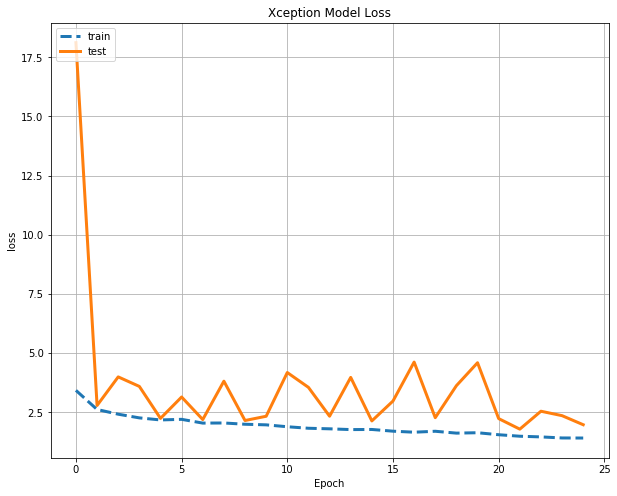

In [39]:
## plot the history of loss and accuracy for train and valid data for the best model, Xception
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10,8))
plt.plot(loss,"--", linewidth=3 , label="train")
plt.plot(val_loss, linewidth=3 , label="valid")

plt.legend(['train','test'], loc='upper left')
plt.grid()
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.title('Xception Model Loss')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [40]:
model.evaluate(x_test, y_test)

12/12 [==============================] - 1s 117ms/step - loss: 1.9779 - accuracy: 0.4453


[1.9779011011123657, 0.4453125]

In [41]:
test_loss, test_accuracy = model.evaluate(x_test, y_test)

print(test_loss,test_accuracy)

12/12 [==============================] - 1s 119ms/step - loss: 1.9779 - accuracy: 0.4453
1.9779011011123657 0.4453125


In [42]:
pred = model.predict(x_test)

pred.shape

(384, 20)

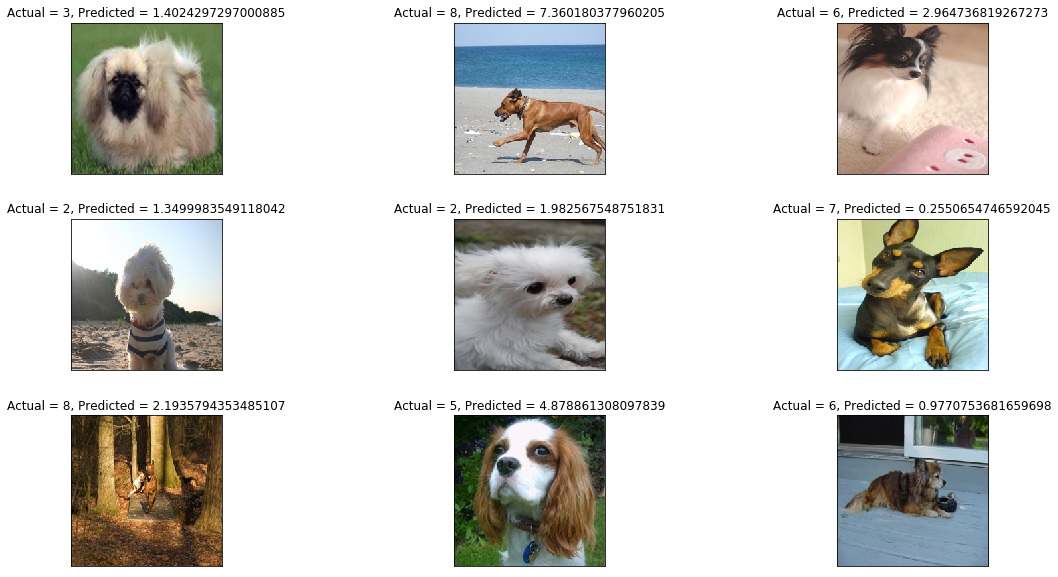

In [43]:
plt.figure(1 , figsize = (19 , 10))
n = 0 

for i in range(9):
    n += 1 
    r = np.random.randint( 0, x_test.shape[0], 1)
    
    plt.subplot(3, 3, n)
    plt.subplots_adjust(hspace = 0.3, wspace = 0.3)
    
    plt.imshow(x_test[r[0]])
    plt.title('Actual = {}, Predicted = {}'.format(y_test[r[0]] , y_test[r[0]]*pred[r[0]][y_test[r[0]]]) )
    plt.xticks([]) , plt.yticks([])

plt.show()